In [1]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy

# Matplotlib related
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# ngmix related
import ngmix
from ngmix.observation import Observation, ObsList, MultiBandObsList
from ngmix.fitting import LMSimple

In [2]:
eps = 0.01 
np.random.seed(869037)

In [3]:
# make a simlated gaussian mixture, convolve it with a PSF and
# render a simulated image
#

# The code is designed to work on multiple images simulaneously, we always
# fit in "sky coordinates".  We do this by making a jacobian to represent
# the transformation, and make sure the center is at our best guess of the
# object location.  In this case we make a unit jacobian.  for non-unit,
# see the ngmix.Jacobian class. 

gal_jacob = ngmix.UnitJacobian(row=16.0, col=16.0)
psf_jacob = ngmix.UnitJacobian(row=12.0, col=12.0)

In [8]:
# parameters for the gaussian mixture
#
# pars for a simple gmix correspond to
#     [cen1, cen2, g1, g2, T, flux]
#
# note T=ixx+iyy, and the center corresponds to an offset relative to the
# jacobian center.  Use cen1,cen2=0,0 for no offset

# exponential disk approximated by gaussians
pars = [0.0, 0.0, 0.2, -0.1, 16.0, 100.0]

gmix0 = ngmix.GMixModel(pars, "dev")

In [9]:
# PSF is a single gaussian
psf_pars = [0.0, 0.0, -0.03, 0.02, 4.0, 1.0]
psf_gmix = ngmix.GMixModel(psf_pars, "gauss")

In [10]:
# convolution with the PSF
gmix = gmix0.convolve(psf_gmix)

In [11]:
# render a simulated image, integrating the model over the pixels
# using 10-point Gauss-Legendre integration

dims = [32, 32]
image0 = gmix.make_image(dims, npoints=10, jacobian=gal_jacob)

In [12]:
psf_dims = [24,24]
psf_im = psf_gmix.make_image(psf_dims, npoints=10, jacobian=psf_jacob)

In [13]:
# add some noise to the galaxy image

sigma = 0.01
noise = np.random.normal(scale=sigma, size=image0.shape)
image = image0 + noise

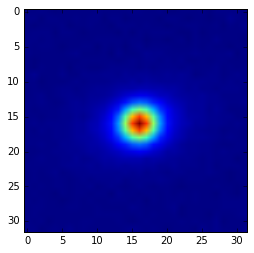

In [14]:
plt.imshow(image)

In [15]:
# fit the data using a maximum likelihood fitter
# we use the LM method, Levenberg-Marquardt
#

# make an observation for the psf image
psf_obs=Observation(psf_im, jacobian=psf_jacob)

# Simple means one of the 6 parameter models
pfitter=LMSimple(psf_obs, 'gauss')

In [18]:
# for simplicity, guess pars before pixelization
guess = np.array(psf_pars)
guess[0] += np.random.uniform(low=-eps, high=eps)
guess[1] += np.random.uniform(low=-eps, high=eps)
guess[2] += np.random.uniform(low=-eps, high=eps)
guess[3] += np.random.uniform(low=-eps, high=eps)
guess[4] *= (1.0 + np.random.uniform(low=-eps, high=eps))
guess[5] *= (1.0 + np.random.uniform(low=-eps, high=eps))

In [20]:
pfitter.go(guess)

psf_gmix_fit=pfitter.get_gmix()

# set the gmix; needed for galaxy fitting later
psf_obs.set_gmix(psf_gmix_fit)

In [21]:
# fit the galaxy.
# Set the weight image for the fit; can be a complex weight
# map in principle

weight = np.zeros(image.shape) + (1 / sigma**2)

In [22]:
# When constructing the Observation we include a weight map and a psf
# observation

obs = Observation(image, weight=weight, jacobian=gal_jacob, psf=psf_obs)

fitter=LMSimple(obs, 'exp')

In [24]:
guess = np.array(pars)
guess[0] += np.random.uniform(low=-eps, high=eps)
guess[1] += np.random.uniform(low=-eps, high=eps)
guess[2] += np.random.uniform(low=-eps, high=eps)
guess[3] += np.random.uniform(low=-eps, high=eps)
guess[4] *= (1.0 + np.random.uniform(low=-eps, high=eps))
guess[5] *= (1.0 + np.random.uniform(low=-eps, high=eps))

In [25]:
fitter.go(guess)

res=fitter.get_result()

ngmix.print_pars(pars, front="truth:")
ngmix.print_pars(res['pars'],front="meas: ")
ngmix.print_pars(res['pars_err'],front="err:  ")

truth:        0         0       0.2      -0.1        16       100 
meas:  0.000305   0.00357     0.158   -0.0764      4.45      85.4 
err:    0.00694   0.00761   0.00692   0.00677    0.0663      0.36 
